In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

In [4]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [5]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [6]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


In [7]:
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}

In [8]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [9]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [10]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    
def build_aspect_dataset(sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=num_workers, worker_init_fn=seed_worker
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=num_workers, worker_init_fn=seed_worker
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [12]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=96):
    ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4, worker_init_fn=seed_worker,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4, worker_init_fn=seed_worker,
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4, worker_init_fn=seed_worker,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4, worker_init_fn=seed_worker,
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def compute_metrics(p, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [15]:
manager = Manager()

aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()

sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()

accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

In [16]:
def train_model(sequence_length, model_name, aspect_metrics, sentiment_metrics, metrics, seed=42, layers_freezed=6, trials=1):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device
    ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

    # Define model
    aspect_model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(sequence_length)
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(EPOCHS):
        aspect_model.train()
        epoch_loss = 0
        
        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))
                
        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()
        
        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            aspect_list
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            aspect_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'aspect-model-{sequence_length}-{layers_freezed}-{trials}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    if accelerator.is_main_process:
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'aspect-model-{sequence_length}-{layers_freezed}-{trials}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("-------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(EPOCHS):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        # accelerator.print("Before gathering:", sentiment_val_outputs[0])
        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        # accelerator.print("After gathering:", sentiment_val_outputs[0])
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            ['negative', 'positive']
        )
        
        # result = compute_metrics_sentiment(type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}))

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                f'sentiment-model-{sequence_length}-{layers_freezed}-{trials}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])
    
    if accelerator.is_main_process:
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained(f'sentiment-model-{sequence_length}-{layers_freezed}-{trials}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    # if accelerator.is_main_process:
    with torch.no_grad():
        # x = 0
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("-------------------------")
        accelerator.print(f"Overall accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
            
    
        if accelerator.is_main_process:
            metrics[0].append(result['accuracy'])
            metrics[1].append(result['f1_micro'])
            metrics[2].append(result['f1_macro'])
    
    accelerator.print(f"Total train time: {duration} s")

In [17]:
# Tokenize each text and calculate their lengths
token_lengths = [len(tokenizer.tokenize(text)) for text in X_train]

# Calculate the average length
average_length = sum(token_lengths) / len(token_lengths)
max_length = max(token_lengths)

print("Average length of tokenized text:", average_length)
print("Max token length:", max_length)

Average length of tokenized text: 24.516863775733682
Max token length: 183


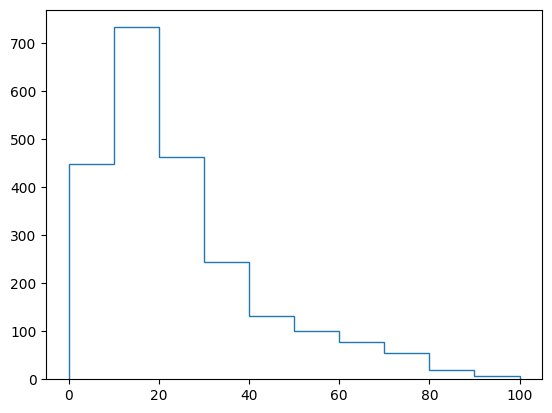

In [18]:
counts, bins = np.histogram(token_lengths, range=(0, 100))
plt.stairs(counts, bins)
plt.show()

# HYPERPARAMETER TUNING

In [19]:
sizes = [8, 16]
lengths = [24, 32, 40, 48]

used_sizes = []
used_lengths = []

for size in sizes:
    BATCH_SIZE = size
    for length in lengths:
        print("=========================================================================================")
        print(f"Batch size: {BATCH_SIZE}, sequence length: {length}")
        used_sizes.append(BATCH_SIZE)
        used_lengths.append(length)
        
        args = (
            length, 
            'indobenchmark/indobert-base-p1', 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros), 
            (accuracies, f1_micros, f1_macros), 
            42, 
            6,
            1
        )
        notebook_launcher(train_model, args, num_processes=2)

Batch size: 8, sequence length: 24
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.9165, F1 Micro: 0.9498, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2449, Accuracy: 0.9347, F1 Micro: 0.9603, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1919, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9401, F1 Micro: 0.9634, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9411, F1 Micro: 0.9637, F1 Macro: 0.9598
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9401, F1 Micro: 0.9631, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9417, F1 Micro: 0.9642, F1 Macro: 0.9613
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9394, F1 Micro: 0.9626, F1 Macro: 0.9594
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9396, F1 Micro: 0.9628, F1 Macro: 0.9595
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3376, Accuracy: 0.8494, F1 Micro: 0.8494, F1 Macro: 0.7931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2036, Accuracy: 0.8678, F1 Micro: 0.8678, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.8718, F1 Micro: 0.8718, F1 Macro: 0.8244
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.8769, F1 Micro: 0.8769, F1 Macro: 0.8366
Epoch 5/10, Train Loss: 0.0937, Accuracy: 0.8759, F1 Micro: 0.8759, F1 Macro: 0.8323
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8429
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.8739, F1 Micro: 0.8739, F1 Macro: 0.8337
Epoch 8/10, Train Loss: 0.0447, Accuracy: 0.8749, F1 Micro: 0.8749, F1 Macro: 0.8361
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.8769, F1 Micro: 0.8769, F1 Macro: 0.8311
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.8779, F1 Micro: 0.8779, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3694, Accuracy: 0.922, F1 Micro: 0.9528, F1 Macro: 0.9501
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.22, Accuracy: 0.9432, F1 Micro: 0.9652, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1286, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9681
Epoch 5/10, Train Loss: 0.1021, Accuracy: 0.9512, F1 Micro: 0.9698, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0791, Accuracy: 0.9535, F1 Micro: 0.9711, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.9536, F1 Micro: 0.9713, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9691
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9536, F1 Micro: 0.9713, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.319, Accuracy: 0.8721, F1 Micro: 0.8721, F1 Macro: 0.8286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2072, Accuracy: 0.8837, F1 Micro: 0.8837, F1 Macro: 0.8488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1383, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.8646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1146, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8697
Epoch 5/10, Train Loss: 0.0859, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8679
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0603, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8775
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8674
Epoch 8/10, Train Loss: 0.0312, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8641
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8765
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3652, Accuracy: 0.9266, F1 Micro: 0.9555, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2067, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1507, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1174, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0935, Accuracy: 0.9587, F1 Micro: 0.9743, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0719, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9703
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3186, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1851, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.875
Epoch 3/10, Train Loss: 0.1251, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8607
Epoch 4/10, Train Loss: 0.0892, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.862
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0602, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0516, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8857
Epoch 7/10, Train Loss: 0.0449, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8654
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8724
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8733
Epoch 10/10, Train Loss: 0.0202, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8787

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3603, Accuracy: 0.9297, F1 Micro: 0.9572, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1965, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1403, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1058, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0837, Accuracy: 0.9644, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0485, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9684, F1 Micro: 0.9804, F1 Macro: 0.9784
Epoch 9/10, Train Loss: 0.0302, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.314, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1686, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1264, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8939
Epoch 4/10, Train Loss: 0.0875, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0681, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8924
Epoch 6/10, Train Loss: 0.052, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8859
Epoch 7/10, Train Loss: 0.0378, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8849
Epoch 8/10, Train Loss: 0.0285, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0311, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9024
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0147, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4285, Accuracy: 0.8832, F1 Micro: 0.9312, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.9269, F1 Micro: 0.9556, F1 Macro: 0.9525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.217, Accuracy: 0.933, F1 Micro: 0.9593, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9363, F1 Micro: 0.9613, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1664, Accuracy: 0.942, F1 Micro: 0.9644, F1 Macro: 0.9613
Epoch 6/10, Train Loss: 0.1375, Accuracy: 0.9401, F1 Micro: 0.9631, F1 Macro: 0.9598
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9389, F1 Micro: 0.9623, F1 Macro: 0.959
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9403, F1 Micro: 0.9632, F1 Macro: 0.9601
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9403, F1 Micro: 0.9631, F1 Macro: 0.96
Epoch 10/10, Train Loss: 0.0676, Accuracy: 0.9401, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8547, F1 Micro: 0.8547, F1 Macro: 0.8082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.87, F1 Micro: 0.87, F1 Macro: 0.8213
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1632, Accuracy: 0.8823, F1 Micro: 0.8823, F1 Macro: 0.8423
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.8864, F1 Micro: 0.8864, F1 Macro: 0.8502
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.8802, F1 Micro: 0.8802, F1 Macro: 0.8421
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.8721, F1 Micro: 0.8721, F1 Macro: 0.8364
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8464
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.8854, F1 Micro: 0.8854, F1 Macro: 0.8483
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8452
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0464, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.426, Accuracy: 0.8852, F1 Micro: 0.9324, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.269, Accuracy: 0.9352, F1 Micro: 0.9605, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9377, F1 Micro: 0.9621, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.9467, F1 Micro: 0.9673, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9523, F1 Micro: 0.9705, F1 Macro: 0.968
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.951, F1 Micro: 0.9697, F1 Macro: 0.9667
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9666
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9521, F1 Micro: 0.9704, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9686
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3435, Accuracy: 0.8519, F1 Micro: 0.8519, F1 Macro: 0.8182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2156, Accuracy: 0.8885, F1 Micro: 0.8885, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1466, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1257, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8637
Epoch 5/10, Train Loss: 0.0859, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8651
Epoch 6/10, Train Loss: 0.0687, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8647
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0379, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8663
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8685
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4247, Accuracy: 0.8865, F1 Micro: 0.9331, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.9378, F1 Micro: 0.9622, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9458, F1 Micro: 0.9669, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9523, F1 Micro: 0.9707, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9582, F1 Micro: 0.974, F1 Macro: 0.9717
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.9569, F1 Micro: 0.9733, F1 Macro: 0.9707
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9566, F1 Micro: 0.9731, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3429, Accuracy: 0.8676, F1 Micro: 0.8676, F1 Macro: 0.8265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2067, Accuracy: 0.8925, F1 Micro: 0.8925, F1 Macro: 0.8617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1357, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0872, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8671
Epoch 5/10, Train Loss: 0.0848, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0476, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8712
Epoch 7/10, Train Loss: 0.0418, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8694
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0226, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8724
Epoch 10/10, Train Loss: 0.0148, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4203, Accuracy: 0.8898, F1 Micro: 0.935, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.9448, F1 Micro: 0.9663, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9484, F1 Micro: 0.9685, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1345, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9765
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.9772
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9674, F1 Micro: 0.9797, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3526, Accuracy: 0.869, F1 Micro: 0.869, F1 Macro: 0.8301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2074, Accuracy: 0.8844, F1 Micro: 0.8844, F1 Macro: 0.844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1358, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0951, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8822
Epoch 5/10, Train Loss: 0.0785, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8782
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.053, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0226, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8876
Higher F1 achi

In [20]:
results = pd.DataFrame({
    'Batch Size': used_sizes,
    'Sequence Length': used_lengths,
    'Aspect Accuracy': list(aspect_accuracies),
    'Aspect F1 Micro': list(aspect_f1_micros),
    'Aspect F1 Macro': list(aspect_f1_macros),
    'Sentiment Accuracy': list(sentiment_accuracies),
    'Sentiment F1 Micro': list(sentiment_f1_micros),
    'Sentiment F1 Macro': list(sentiment_f1_macros),
    'Accuracy': list(accuracies),
    'F1 Micro': list(f1_micros),
    'F1 Macro': list(f1_macros),
})

results.to_csv(f'hoasa-hyperparameters-tuning.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

trial = 1
for seed in seeds:
    print("=====================")
    print("SEED:", seed)
    set_seed(seed)
    
    LEARNING_RATE = 2e-5
    BATCH_SIZE = 16
    args = (
        48, 
        'indobenchmark/indobert-base-p1', 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros), 
        (accuracies, f1_micros, f1_macros), 
        42, 
        6,
        trial
    )
    
    notebook_launcher(train_model, args, num_processes=2)

    trial += 1

SEED: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.42, Accuracy: 0.8906, F1 Micro: 0.9353, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.941, F1 Micro: 0.9641, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9512, F1 Micro: 0.9701, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.341, Accuracy: 0.8677, F1 Micro: 0.8677, F1 Macro: 0.8272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8679
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1384, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0895, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0662, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8813
Epoch 6/10, Train Loss: 0.0561, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8754
Epoch 7/10, Train Loss: 0.0406, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8819
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4435, Accuracy: 0.8809, F1 Micro: 0.9301, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.9399, F1 Micro: 0.9634, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.949, F1 Micro: 0.9688, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3331, Accuracy: 0.8718, F1 Micro: 0.8718, F1 Macro: 0.8374
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1863, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1389, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0966, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0819, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0609, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8894
Epoch 7/10, Train Loss: 0.039, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8886
Epoch 8/10, Train Loss: 0.0344, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8879
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8843
Epoch 10/10, Train Loss: 0.0187, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4357, Accuracy: 0.879, F1 Micro: 0.9292, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.9349, F1 Micro: 0.9605, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.9484, F1 Micro: 0.9685, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0576, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3325, Accuracy: 0.8676, F1 Micro: 0.8676, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1884, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1168, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0856, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0594, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0358, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8902
Epoch 7/10, Train Loss: 0.0396, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0291, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9007
Epoch 9/10, Train Loss: 0.0255, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8889
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4217, Accuracy: 0.888, F1 Micro: 0.9336, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2478, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9502, F1 Micro: 0.9695, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1362, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0548, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3342, Accuracy: 0.8629, F1 Micro: 0.8629, F1 Macro: 0.8212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1977, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8725
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1299, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0934, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0841, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0569, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8934
Epoch 7/10, Train Loss: 0.0383, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8784
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8846
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8773
Epoch 10/10, Train Loss: 0.0262, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4368, Accuracy: 0.8851, F1 Micro: 0.932, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.256, Accuracy: 0.9415, F1 Micro: 0.9644, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1377, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3456, Accuracy: 0.8799, F1 Micro: 0.8799, F1 Macro: 0.8446
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1711, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1188, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.099, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0669, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.051, Accuracy: 0.9193, F1 Micro: 0.9193, F1 Macro: 0.8943
Epoch 7/10, Train Loss: 0.0399, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8876
Epoch 8/10, Train Loss: 0.0264, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.8917
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9193, F1 Micro: 0.9193, F1 Macro: 0.8943
Higher

In [22]:
results = pd.DataFrame({
    'Trial': [1,2,3,4,5],
    'Aspect Accuracy': list(aspect_accuracies),
    'Aspect F1 Micro': list(aspect_f1_micros),
    'Aspect F1 Macro': list(aspect_f1_macros),
    'Sentiment Accuracy': list(sentiment_accuracies),
    'Sentiment F1 Micro': list(sentiment_f1_micros),
    'Sentiment F1 Macro': list(sentiment_f1_macros),
    'Accuracy': list(accuracies),
    'F1 Micro': list(f1_micros),
    'F1 Macro': list(f1_macros),
})

results.to_csv(f'hoasa-passive-results.csv', index=False)